In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import os

import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod
from gewitter_functions import get_acc

## Inputs
batch_size = 32
epoch_num = 10




2024-03-21 13:44:36.580221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ds_train = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Data_CNN/train_trim.nc').isel(time = slice (0,2000))
ds_val = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Data_CNN/validate.nc').isel(time = slice (500,800))



In [3]:
train_random_shuffle = np.arange(len(ds_train.features))
np.random.shuffle(train_random_shuffle )

X_train = ds_train.features.values[train_random_shuffle]
# Y_train = ds_train.labels_1d.values[train_random_shuffle]
Y_train = ds_train.labels_1d.values[:,1:][train_random_shuffle]


time_train = ds_train.time[train_random_shuffle]

val_random_shuffle = np.arange(len(ds_val.features))
np.random.shuffle(val_random_shuffle)
X_val = ds_val.features.values[val_random_shuffle]
# Y_val = ds_val.labels_1d.values[val_random_shuffle]
Y_val = ds_val.labels_1d.values[:,1:][val_random_shuffle]
time_val = ds_val.time[val_random_shuffle]

train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

#batch both 
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)

for batch in train_data:
    break 
for batch in val_data:
    break 



2024-03-21 13:45:01.755493: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-03-21 13:45:04.277609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2000,20]
	 [[{{node Placeholder/_1}}]]
2024-03-21 13:45:04.410674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [300,20]
	 [[{{node Placeholder/_1}}]]


In [51]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(100, (2, 2), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer

#     tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.GlobalAveragePooling2D(),

#     tf.keras.layers.Dense(200, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(100, activation='relu'),
#     tf.keras.layers.Dense(2,activation='sigmoid'),
# ])

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(20, (2, 2), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Conv2D(20, (2, 2), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Conv2D(50, (10, 10), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.GlobalAveragePooling2D(),

#     tf.keras.layers.Dense(100, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(100, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(21,activation='sigmoid'),

#     tf.keras.layers.Dense(20,activation='sigmoid'),
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer

    tf.keras.layers.Conv2D(200, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    tf.keras.layers.Flatten(),
    

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(20,activation='sigmoid'),
])

In [52]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 144, 90, 32)       2912      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 144, 90, 32)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 72, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 45, 200)       57800     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 72, 45, 200)       0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 22, 200)      0         
 g2D)                                                 

In [53]:

# model.compile(loss="categorical_crossentropy",
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

# model.compile(loss='mse',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])


In [ ]:
history = model.fit(train_data,validation_data=val_data,epochs=epoch_num)


Epoch 1/10
63/63 [==============================] - 20s 300ms/step - loss: 0.4354 - accuracy: 0.1105 - val_loss: 0.2235 - val_accuracy: 0.0867
Epoch 2/10
63/63 [==============================] - 17s 265ms/step - loss: 0.2849 - accuracy: 0.1860 - val_loss: 0.1704 - val_accuracy: 0.1267
Epoch 3/10
63/63 [==============================] - 17s 265ms/step - loss: 0.2142 - accuracy: 0.1830 - val_loss: 0.1513 - val_accuracy: 0.1467
Epoch 4/10
63/63 [==============================] - 17s 271ms/step - loss: 0.1760 - accuracy: 0.1690 - val_loss: 0.1475 - val_accuracy: 0.1467
Epoch 5/10
63/63 [==============================] - 17s 264ms/step - loss: 0.1496 - accuracy: 0.1765 - val_loss: 0.1398 - val_accuracy: 0.1267
Epoch 6/10
63/63 [==============================] - 17s 269ms/step - loss: 0.1296 - accuracy: 0.1735 - val_loss: 0.1303 - val_accuracy: 0.1233
Epoch 7/10
45/63 [====================>.........] - ETA: 4s - loss: 0.1165 - accuracy: 0.1833

In [42]:
history_pd = pd.DataFrame(history.history)
y_preds_distribution = model.predict(val_data)


results_pd = pd.DataFrame(y_preds_distribution)
results_pd = results_pd.set_index(np.array(time_val))

val_pd = pd.DataFrame(Y_val)
val_pd = val_pd.set_index(np.array(time_val))


10/10 [==============================] - 0s 41ms/step


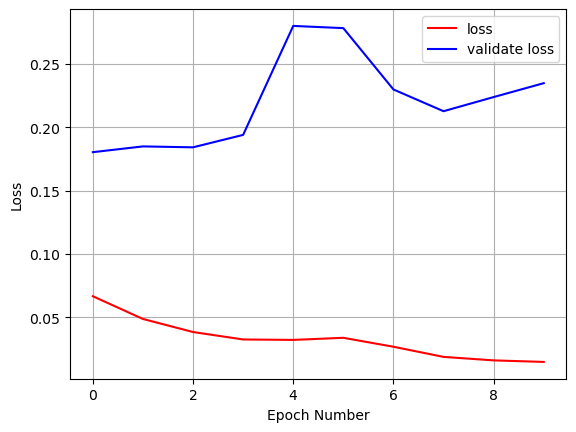

In [43]:
plt.plot(history_pd['loss'],'-r', label = 'loss')
plt.plot(history_pd['val_loss'],'-b', label = 'validate loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


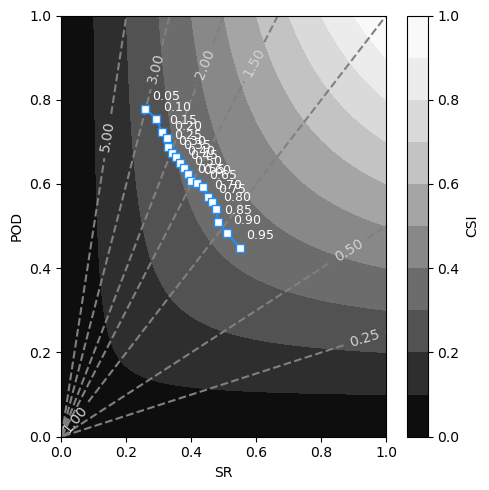

In [44]:
#ravel both
y_v_rav =np.array(val_pd).ravel()
y_preds_rav = np.array(results_pd).ravel()

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)


#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,fontsize=9,color='white')

plt.tight_layout();

In [45]:
cutoff = .5

predict_pd = np.zeros((len(results_pd.columns), len(results_pd)))
for c in range(len(results_pd.columns)):
    predict_pd[c] = np.where(results_pd[c]>cutoff,1,0).squeeze()
predict_pd = pd.DataFrame(predict_pd.T, index = results_pd.index)

#the contingency table calculator expects y_true,y_pred
cont_table = get_contingency_table(np.array(val_pd),np.array(predict_pd))

accuracy = get_acc(cont_table)
print('Binary Accuracy = {}%'.format(np.round(accuracy,0))), cont_table

Binary Accuracy = 94.0%


(None,
 {'num_true_positives': 178,
  'num_false_positives': 107,
  'num_false_negatives': 279,
  'num_true_negatives': 5436})

In [46]:
print('number of true positives (actual): ' +str(np.sum(np.array(val_pd))))
print('number of true negatives (actual): ' +str(np.sum(np.where(np.array(val_pd) ==0,1,0))))

number of true positives (actual): 285
number of true negatives (actual): 5715


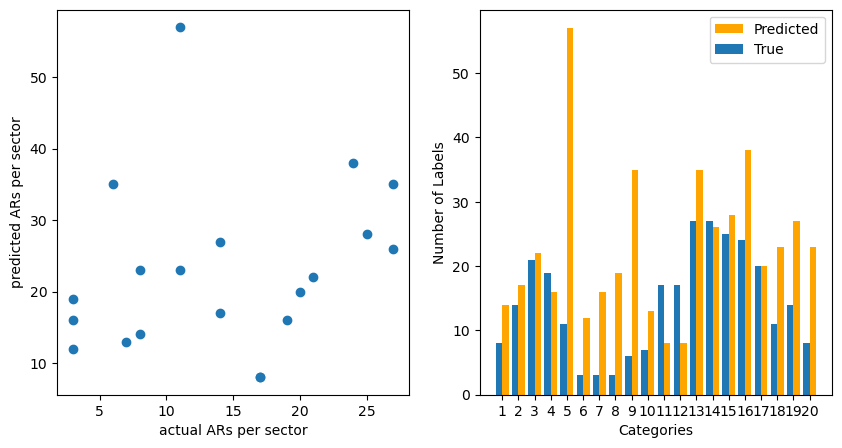

In [47]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(np.sum(np.array(val_pd),0), np.sum(np.array(predict_pd),0))
ax[0].set_ylabel('predicted ARs per sector')
ax[0].set_xlabel('actual ARs per sector')

ax[1].bar(np.arange(0,20)+.2, np.sum(np.array(predict_pd),0), width= .4,  color = 'orange', label = 'Predicted')
ax[1].bar(np.arange(0,20)-.4, np.sum(np.array(val_pd), axis = 0), width =.4, align = 'edge', label = 'True')

ax[1].set_ylabel('Number of Labels')
ax[1].set_xlabel('Categories')
ax[1].set_xticks(np.arange(0,20,1))
ax[1].set_xticklabels(['1','2','3','4','5','6','7','8','9','10', '11','12','13','14','15','16','17','18','19','20'])
ax[1].legend()


### check out one timestep of data

In [48]:
pd.DataFrame(np.array(batch[1]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Predicted Likelihood')

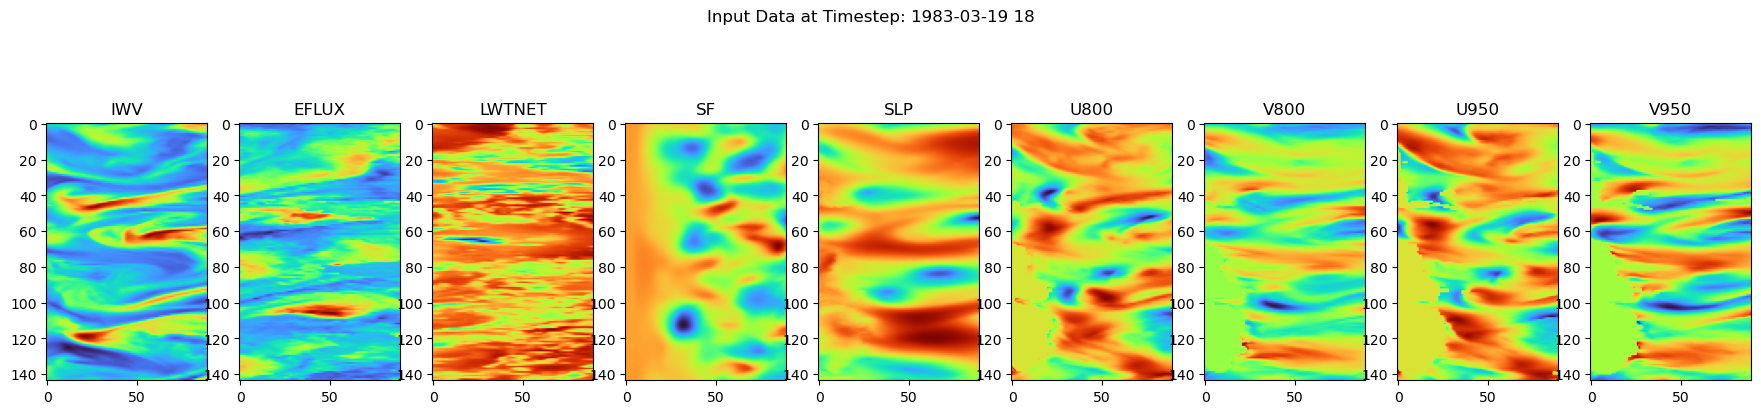

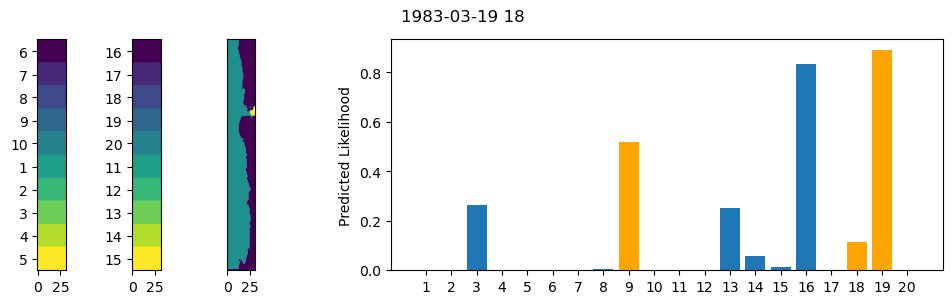

In [50]:
n = 22

#get the features for example 12 in this batch 
one_example_features = batch[0][n]
#get the label for that same example 
one_example_label = batch[1][n]

Y_data = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Y_labels_AR_PRECSN_T/'+str(pd.to_datetime(time_val[n].values).year))
Y_visual_data = xr.where(Y_data.Y>=1000,1, 0) 
Y_visual_data = xr.where(Y_data.Y.isin([100, 101, 110, 111, 1100, 1101, 1110, 1111]),2, Y_visual_data ) 
Y_visual_data = Y_visual_data.sel(time = time_val[n].values).values.T

# Make category visual
lons = np.shape(batch[0])[1]
start = np.round(np.arange(0,lons,lons/10))
end = np.round(np.arange(lons/10,lons+lons/10, lons/10))
show_categories = np.zeros((np.shape(batch[0])[0:2][1],np.shape(batch[0])[0:2][0]))
for c in range(10):
    show_categories[int(start[c]):int(end[c]),:] = c+1

#get the features for example 12 in this batch 
one_example_features = batch[0][n]
#get the label for that same example 
one_example_label = batch[1][n]

titles = ['IWV', 'EFLUX', 'LWTNET', 'SF', 'SLP', 'U800', 'V800','U950', 'V950']

fig,axes = plt.subplots(1,9,figsize=(22,5))
fig.suptitle('Input Data at Timestep: '+str(pd.to_datetime(time_val[n].values))[0:13])
axes = axes.flatten()
for a in range(len(axes)):
    axes[a].imshow(one_example_features[:,:,a],cmap='turbo')
    axes[a].set_title(titles[a])

# Make category visual
lons = np.shape(Y_visual_data)[0]
start = np.round(np.arange(0,lons,lons/10))
end = np.round(np.arange(lons/10,lons+lons/10, lons/10))
show_categories = np.zeros((np.shape(Y_visual_data)[0],np.shape(Y_visual_data)[1]))
for c in range(10):
    show_categories[int(start[c]):int(end[c]),:] = c+1

    

fig = plt.figure(figsize=(12, 3), constrained_layout=False)
fig.suptitle(str(pd.to_datetime(time_val[n].values))[0:13])
gs = fig.add_gridspec(1, 10)
ax1 = fig.add_subplot(gs[0, :1])
ax4 = fig.add_subplot(gs[0, 1:2])
ax2 = fig.add_subplot(gs[0,2:3])
ax3 = fig.add_subplot(gs[0, 4:])

# ax1.imshow(show_categories, cmap = 'jet')
# ax4 = ax1.twinx()
ax1.set_yticks(np.round(np.arange(0,lons,lons/10))+lons/20)
ax1.set_yticklabels(['6','7','8','9','10','1','2','3','4','5',])
# ax4.set_yticklabels(['16','17','18','19','20','11','12','13','14','15',])
ax1.imshow(show_categories)


ax4.set_yticks(np.round(np.arange(0,lons,lons/10))+lons/20)
ax4.set_yticklabels(['16','17','18','19','20','11','12','13','14','15',])
ax4.imshow(show_categories)


ax2.imshow(Y_visual_data, )
ax2.set_yticks([])

ax3.bar(np.arange(0,20,1),results_pd.iloc[n])
ax3.bar(np.argwhere(val_pd.iloc[n] == 1).squeeze(),results_pd.iloc[n][np.argwhere(val_pd.iloc[n] == 1).squeeze()], color = 'orange')
ax3.set_xticks(np.arange(0,20,1), ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']);
ax3.set_ylabel('Predicted Likelihood')
    

## look at model layers

In [22]:
## Checkout certain layer 
for l,layer in enumerate(model.layers):
    print(l,layer.name)

0 conv2d_9
1 leaky_re_lu_9
2 max_pooling2d_6
3 conv2d_10
4 leaky_re_lu_10
5 max_pooling2d_7
6 conv2d_11
7 leaky_re_lu_11
8 flatten_2
9 dense_12
10 dense_13


In [47]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d_1')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(val_data)

#grab a batch to look at 
for batch in val_data:
    break 


10/10 [==============================] - 2s 166ms/step


In [48]:
np.shape(convolved_images)

(300, 144, 90, 50)

In [49]:
plot_convolved_images = convolved_images[0]
np.shape(plot_convolved_images)

(144, 90, 50)

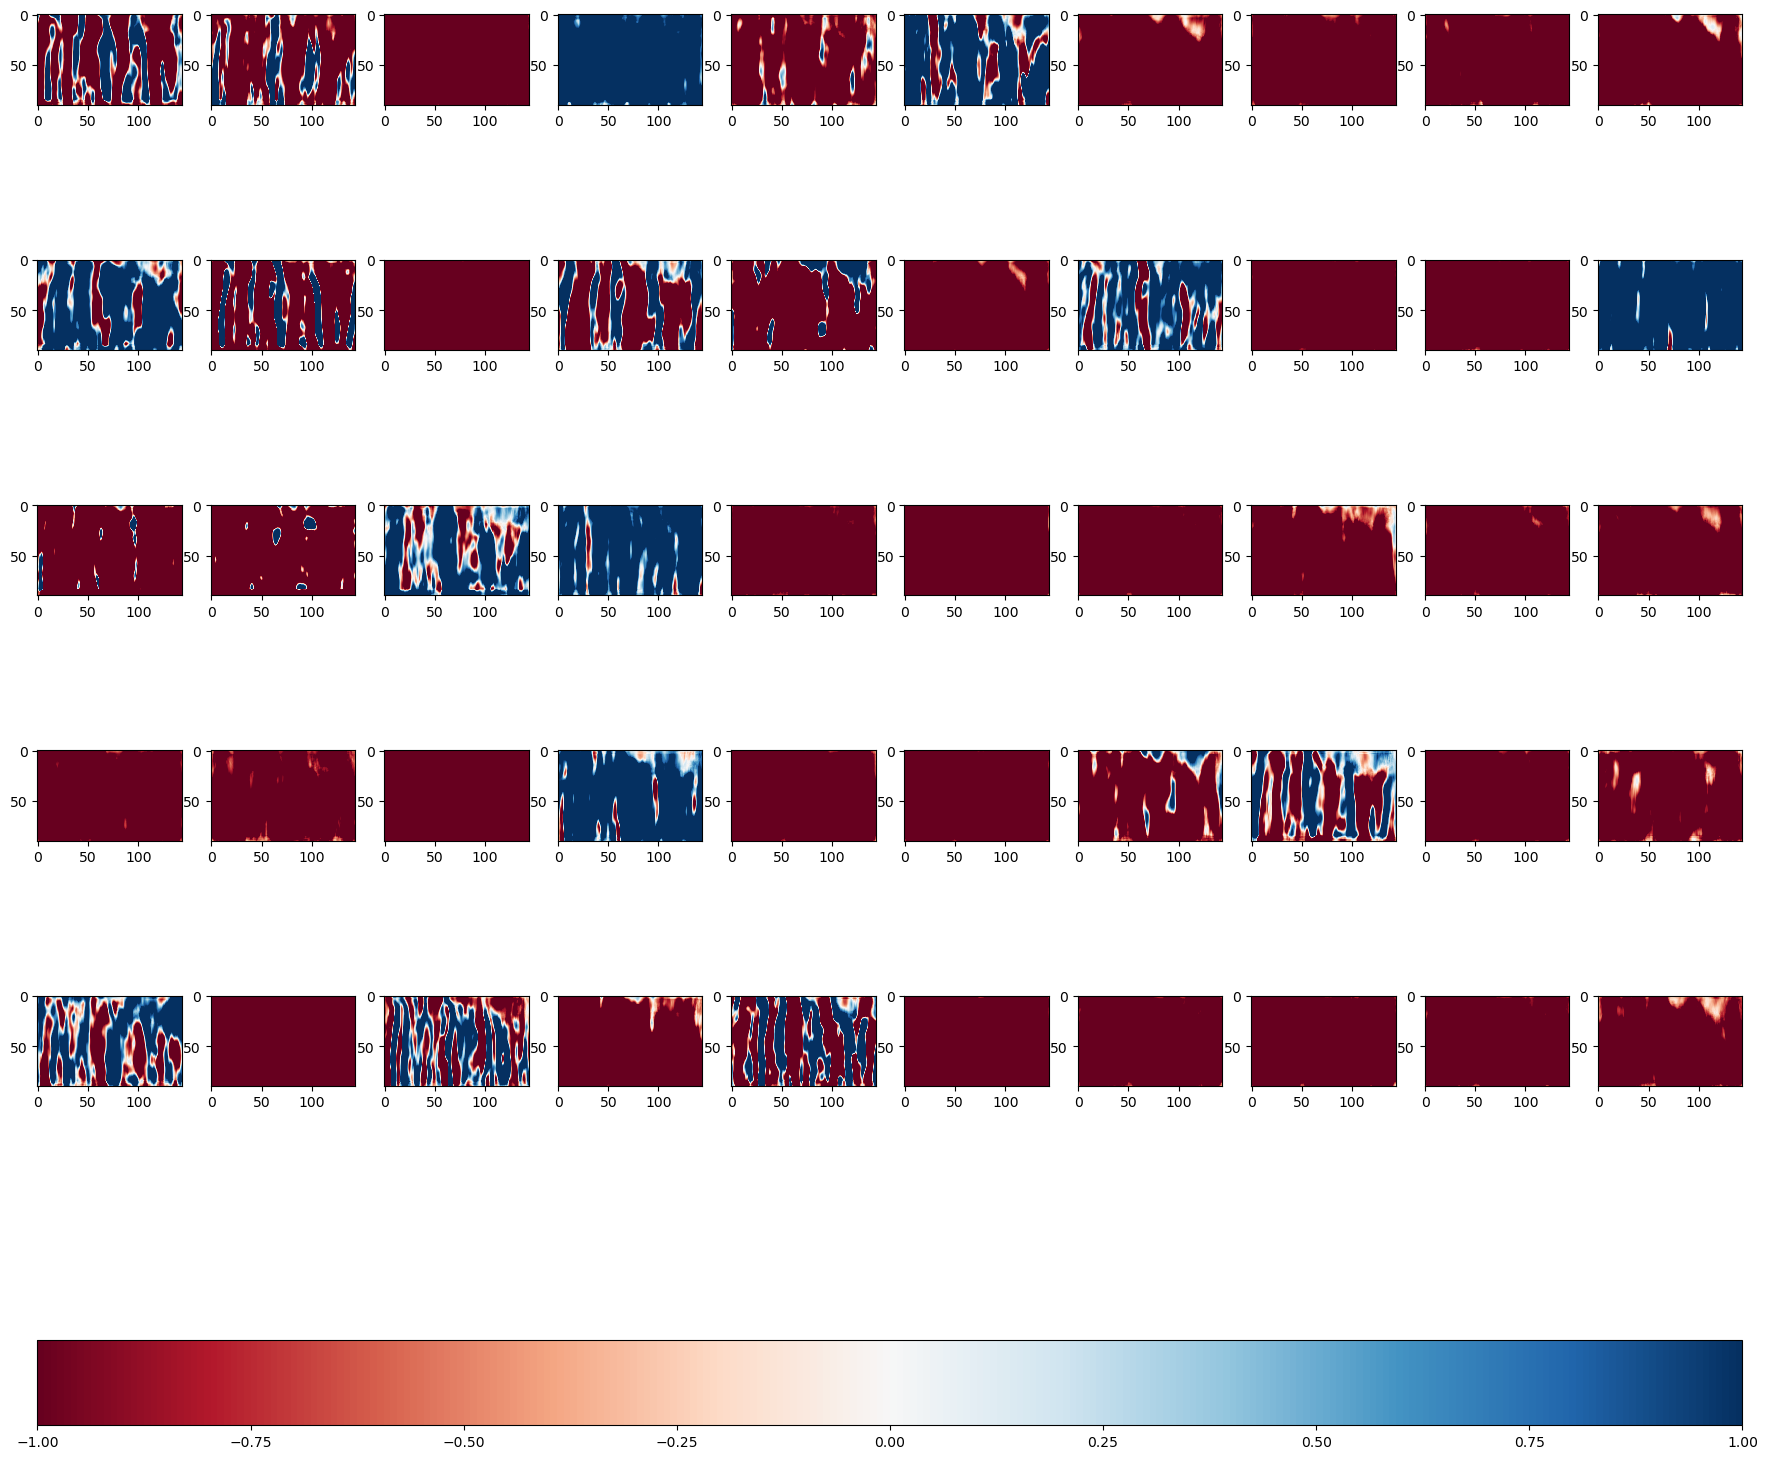

In [50]:

fig,ax = plt.subplots(5,10,figsize=(22,22))
axes = ax.flatten()
for a in range(len(axes)):
    im = axes[a].imshow(plot_convolved_images[:,:,a].T, vmin = -1, vmax = 1,cmap='RdBu')
fig.colorbar(im, ax = axes.ravel(), orientation = 'horizontal')
    



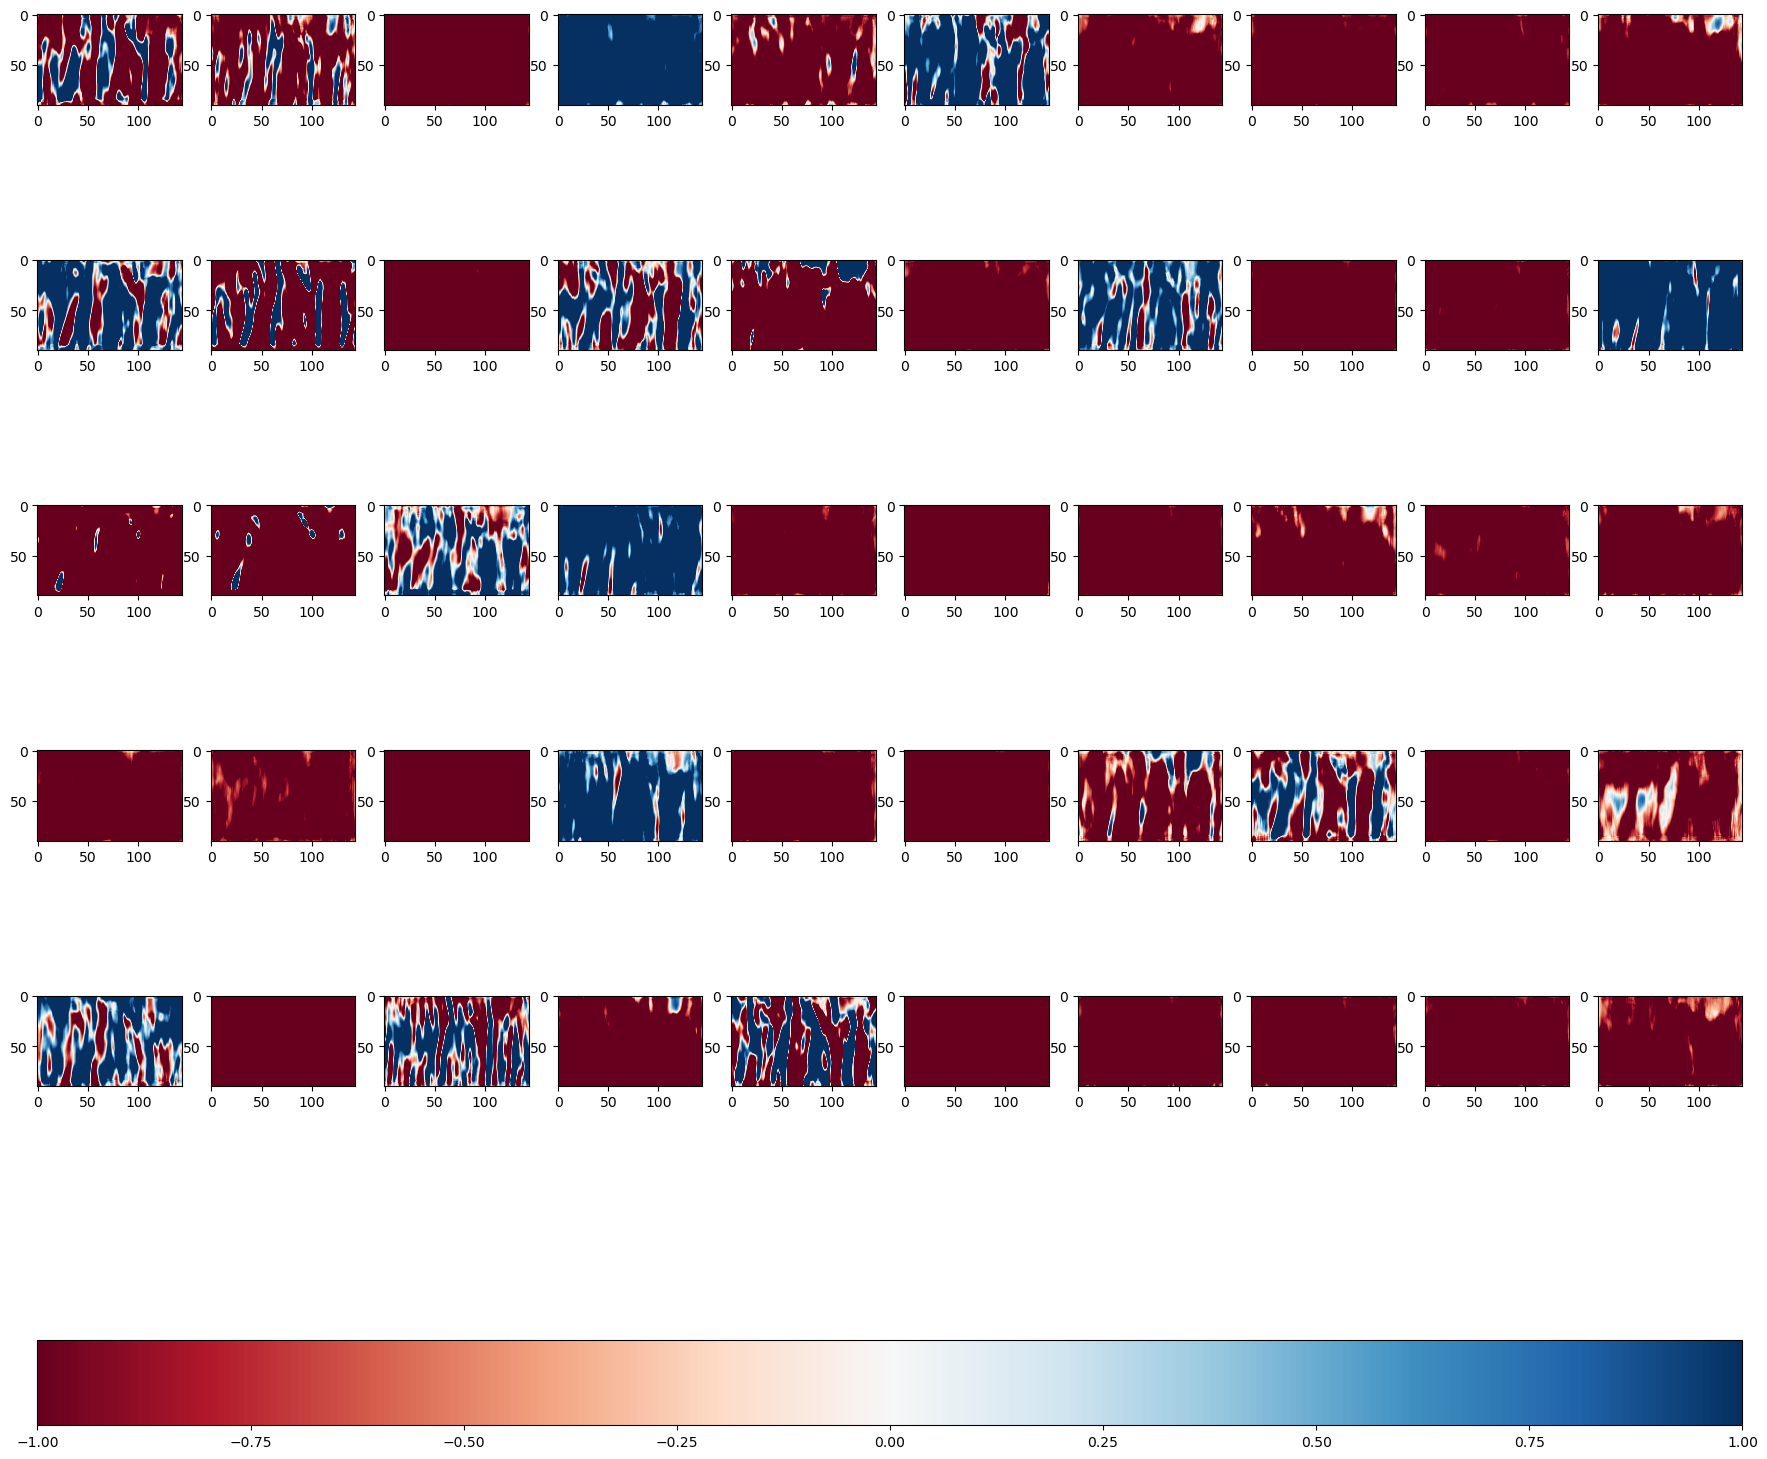

In [52]:
plot_convolved_images = convolved_images[20]
fig,ax = plt.subplots(5,10,figsize=(22,22))
axes = ax.flatten()
for a in range(len(axes)):
    im = axes[a].imshow(plot_convolved_images[:,:,a].T, vmin = -1, vmax = 1,cmap='RdBu')
fig.colorbar(im, ax = axes.ravel(), orientation = 'horizontal')
    

